# Quantum Counting
Whereas Grover’s algorithm attempts to find a solution to the Oracle, the quantum counting algorithm tells us how many of these solutions there are. This algorithm is interesting as it combines both quantum search and quantum phase estimation.


In [1]:
from qiskit import *
import numpy as np
from math import pi, sqrt
import random
import time

from qiskit.visualization import array_to_latex
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import random_state

In [2]:
backend = Aer.get_backend('statevector_simulator')
def getBloch(quantumCircuit):
    return visualization.plot_bloch_multivector(execute(quantumCircuit, backend).result().get_statevector())

In [3]:
def stateGenerator(state):
    state = state[::-1]
    current = int(state, 2)
#     print('Current state: ', current)
    newState = [0 for i in range(0, 2**(len(state)))]
    newState[current] = 1
#     print('Init state array: ',newState)
    return newState

In [4]:
def getMeasure(quantumCircuit, n):
    measures = []
    for i in range(0,n):
        outcome = execute(quantumCircuit, backend).result()
        hist = outcome.get_counts()
        for i in hist.keys():
            measures.append(i)
    return measures

In [5]:
def makeCirc(n, state):
    initState = state
    print('Init state = ',initState)
    qr = QuantumRegister(n,"q")
    qc = ClassicalRegister(n, "c")
    circ = QuantumCircuit(qr, qc)
    initializedState = stateGenerator(initState)
    circ.initialize(initializedState, qr)
    return circ

In [6]:
def getHistogram(n, circ):
    qasm_sim = Aer.get_backend('qasm_simulator')
    shots = n
    qboj = assemble(circ, shots=shots)
    results = qasm_sim.run(qboj).result()
    counts = results.get_counts()
    return counts

In [7]:
def getPTrace(quantumCircuit, n):
    return quantum_info.partial_trace(execute(quantumCircuit, backend).result().get_statevector(), n)

In [8]:
def cccZ():
    #Triple Control Z Rotation
    # Rotate on the Z axis when 3 controlled qubit are 1
    qc = QuantumCircuit(4)
    qc.cp(pi/4, 0, 3)
    qc.cx(0, 1)
    qc.cp(-pi/4, 1, 3)
    qc.cx(0, 1)
    qc.cp(pi/4, 1, 3)
    qc.cx(1, 2)
    qc.cp(-pi/4, 2, 3)
    qc.cx(0, 2)
    qc.cp(pi/4, 2, 3)
    qc.cx(1, 2)
    qc.cp(-pi/4, 2, 3)
    qc.cx(0, 2)
    qc.cp(pi/4, 2, 3)
    gate = qc.to_gate(label=' cccZ')
    return gate

In [9]:
def groverDiffusionOp():
    #Inversion along the mean
    circ = QuantumCircuit(4)
    circ.h(range(4))
    circ.x(range(4))
    circ.append(cccZ(), [0, 1, 2, 3])
    circ.x(range(4))
    circ.h(range(4))
    gate = circ.to_gate(label=" Diffusion")
    return gate

In [10]:
def groverOracle(n):
    #Takes in 4-bit string and returns Gate
    #Grover Oracle
    #Inversion
    circ = QuantumCircuit(4)
    if (n[3] != str(1)):
        circ.x(0)
    if (n[2] != str(1)):
        circ.x(1)
    if (n[1] != str(1)):
        circ.x(2)
    if (n[0] != str(1)):
        circ.x(3)
    circ.append(cccZ(), [0, 1, 2, 3])
    if (n[3] != str(1)):
        circ.x(0)
    if (n[2] != str(1)):
        circ.x(1)
    if (n[1] != str(1)):
        circ.x(2)
    if (n[0] != str(1)):
        circ.x(3)
    gate = circ.to_gate(label=' Grover Oracle')
    return gate

In [11]:
def groverIterate(inp):
    circ = QuantumCircuit(4)
    circ.append(groverOracle(inp), [0, 1, 2, 3])
    circ.append(groverDiffusionOp(), [0, 1, 2, 3])
    gate = circ.to_gate(label = ' Grover Iterate')
    return gate

In [33]:
cgrit = groverIterate('0000').control()

In [34]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(4)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [35]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = "QFT†"

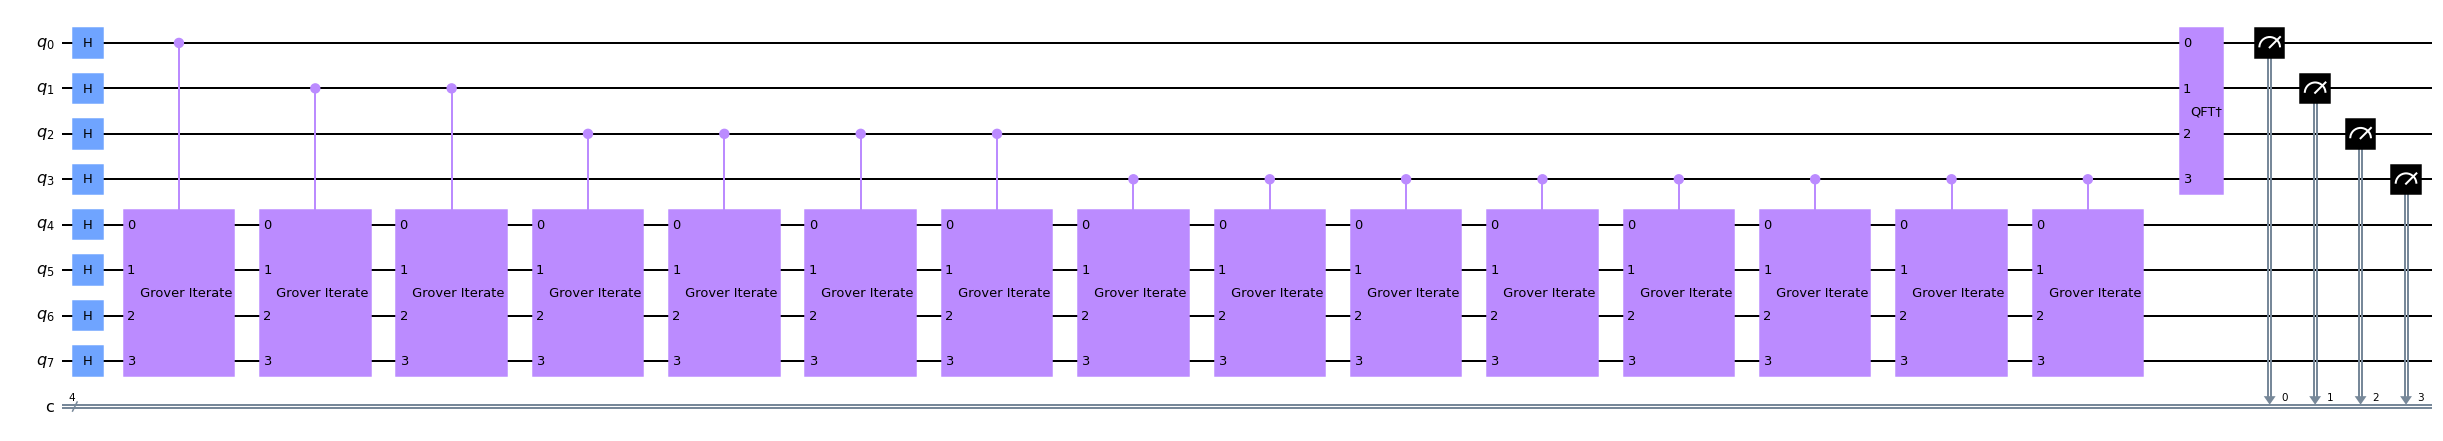

In [36]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw(fold=-1);

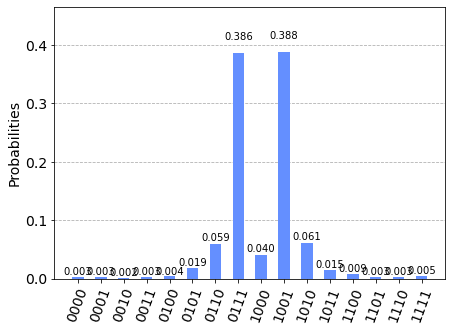

In [37]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist);

In [38]:
measured_str = max(hist, key=hist.get)

In [39]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 9


In [40]:
theta = (measured_int/(2**t))*pi*2
print("Theta = %.5f" % theta)

Theta = 3.53429


In [41]:
from math import sin

In [42]:
N = 2**n
M = N * (sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 0.6


In [43]:
m = t - 1 # Upper bound: Will be less than this 
err = (sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.90


In [44]:
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)